# Tópicos do Capítulo:

* Preparação de texto para treinamento de modelo de linguagem grande;
* **Tokenização** de palavras e subpalavras;
* Codificação de **pares de bytes** como uma forma mais avançada de tokeniza texto;
* Amostragem de exemplos de treinamento com abordagem de janela deslizante;
* Converção de tokens em vetores (embeddings) que alimentam um grande modelo de linguagem;



In [ ]:
# Importação para Visualizações:
import cv2
from matplotlib import pyplot as plt

**Funções Auxiliares**

    Todas as funções auxiliares construidas para ajudar na elaboração do código
    serão alocadas aqui nesse código, de modo que sejam faceis de serem encontradas.


In [ ]:
# Visualização de imagens:
def visualization(img, escala_cores=None, fig=None, text=None):

  # Carregar a imagem:
  if escala_cores != None:
    imagem = cv2.imread(img, escala_cores)

  else:
    imagem = cv2.imread(img)

  # Construindo a imagem:
  try:
      # Mostrar a imagem usando matplotlib
      plt.figure(figsize=(12, 12))
      plt.imshow(imagem, cmap='gray')
      if text != None:
        plt.text(0.5, 0.5, fig, ha='center')
      plt.axis('off')
      plt.show()

      if text != None:
        try:
          print(text)
        except Exception as erro_text:
          print(f'Entrada inválida para texto: {erro_text}')

  except Exception as erro_imagem:
      print(f"Erro ao carregar a imagem: {erro_imagem}")

# Recapitulando:

    No capítulo anterior, aprofundamos na estrutura geral dos grandes modelos
    de linguagem (LLMs) e aprendemos que eles são pré-treinados em vastas
    quantidades de texto. Especificamente, nosso foco estava nos LLMs apenas
    decodificadores baseados na arquitetura transformer, que é a base do
    ChatGPT e de outros LLMs populares semelhantes ao GPT.

    Durante a fase de pré-treinamento, os LLMs processam o texto uma palavra
    de cada vez. Treinar LLMs com milhões a bilhões de parâmetros usando uma
    tarefa de previsão da próxima palavra produz modelos com capacidades
    impressionantes. Esses modelos podem então ser ainda mais ajustados para
    seguir instruções gerais ou realizar tarefas específicas. Mas antes de
    podermos implementar e treinar LLMs nos próximos capítulos, precisamos
    preparar o conjunto de dados de treinamento, que é o foco deste capítulo,
    conforme ilustrado na Figura 2.1.








In [ ]:
# Baixando imagem:
!curl -o fig2_1.png https://drek4537l1klr.cloudfront.net/raschka/v-5/Figures/02__image001.png

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  147k  100  147k    0     0   338k      0 --:--:-- --:--:-- --:--:--  338k


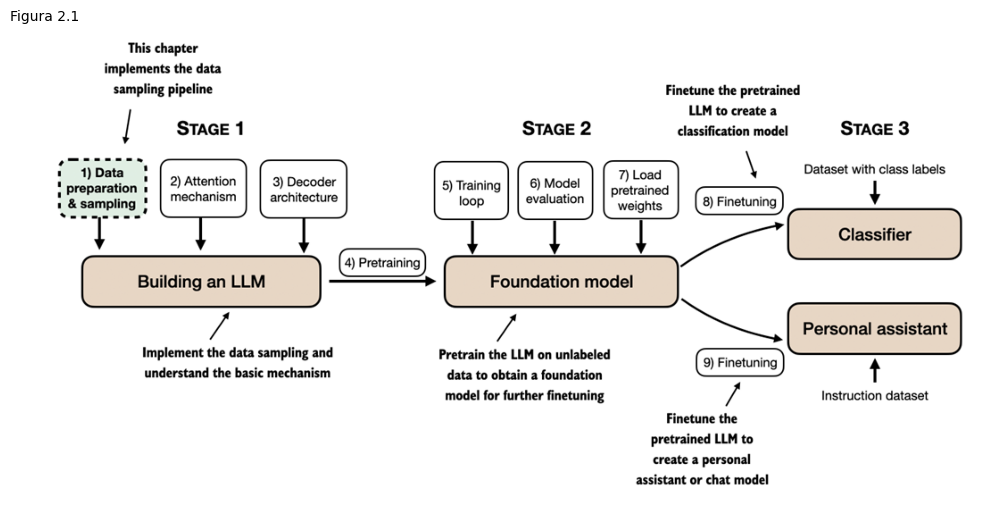


Um modelo mental das três principais etapas de codificação de um LLM,
pré-treinando o LLM em um conjunto de dados de texto geral e ajustando-o
em um conjunto de dados rotulado. Este capítulo explicará e codificará o
preparo dos dados e o pipeline de amostragem que fornece ao LLM os dados
de texto para pré-treinamento.



In [ ]:
# Carregar a imagem:
visualization('fig2_1.png', fig='Figura 2.1', text= '''
Um modelo mental das \033[1mtrês principais etapas de codificação\033[0m de um LLM,
pré-treinando o LLM em um conjunto de dados de texto geral e ajustando-o
em um conjunto de dados rotulado. Este capítulo explicará e \033[1mcodificará o
preparo dos dados\033[0m e o \033[1mpipeline de amostragem\033[0m que fornece ao LLM os dados
de texto para \033[1mpré-treinamento\033[0m.
''')

**Objetivo do Capítulo**

     Neste capítulo, aprenderemos como preparar o texto de entrada para
     treinar LLMs. Isso envolve dividir o texto em tokens individuais de
     palavras e subpalavras, que podem então ser codificados em representações
     vetoriais para o LLM. Você também aprenderá sobre esquemas avançados de
     tokenização, como a codificação de pares de bytes, que é utilizada em
     LLMs populares como o GPT. Por fim, implementaremos uma estratégia de
     amostragem e carregamento de dados para produzir os pares de entrada e
     saída necessários para treinar LLMs nos capítulos subsequentes.

# 2.1 Entendendo o mundo das representações (Embeddings):

    Computadores, em sua essência, são máquinas de calcular, não entendem
    o que são palavras, muito menos suas construções linguísticas como frases,
    ou textos, o que, na linguagem da ciência da computação, chamamos de
    sequências (Vetores não de números, mas de caracteres). Deste modo, não
    conseguimos simplesmente alimentar o nosso modelo com esses conjuto de
    dados bruto, cru,  precisamos de uma maneira de representar palavras,
    essas sequências de caracteres, como vetores numéricos cujo os valores
    estejam no domino dos contínuos.

    (Para leitores não familiarizados com vetores e tensores em um contexto
    computacional o livro dispobiliza uma introdução ao tema no Apêndice A,
    seção A2.2 Entendendo tensores.)

**Embeddings**

    O conceito de transformar dados em um formato vetorial é frequentemente
    chamado de embedding. Em sua essência, um embedding é um mapeamento de
    objetos discretos, como palavras, imagens ou até mesmo documentos inteiros,
    para pontos em um espaço vetorial contínuo - o principal objetivo desses
    vetores de representação é converter dados não numéricos em um formato que
    redes neurais possam processar.Usando uma camada específica da rede neural
    ou outro modelo de rede neural pré-treinado, podemos incorporar diferentes
    tipos de dados, por exemplo, vídeo, áudio e texto, como ilustrado na Figura 2.2.

In [ ]:
# Baixando imagem:
!curl -o fig2_2.png https://drek4537l1klr.cloudfront.net/raschka/v-5/Figures/02__image003.png

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 92411  100 92411    0     0   232k      0 --:--:-- --:--:-- --:--:--  231k


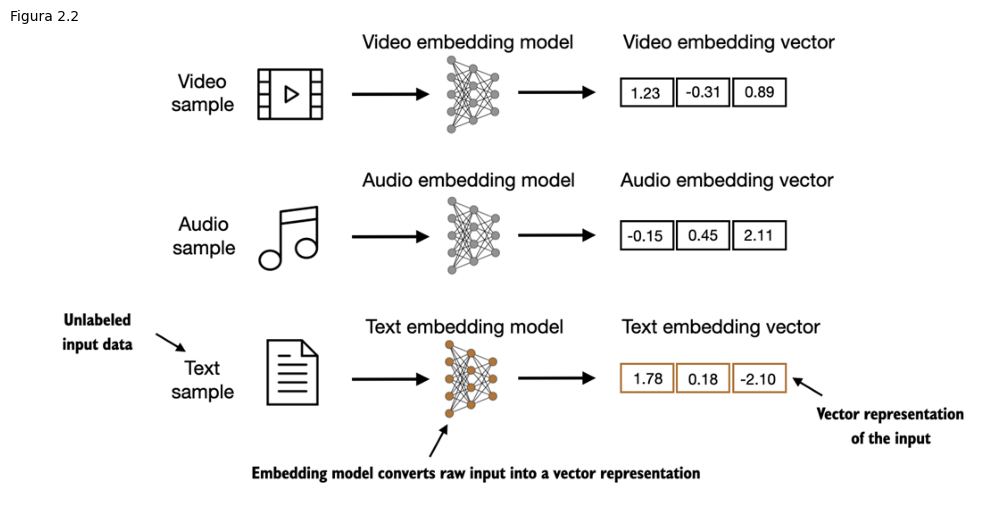


Além de sequencias, os modelos de deep leaning não conseguem processar formatos
de dados como vídeo e áudio em sua forma bruta. Assim, usamos um modelo de
embedding (modelo que cria as representações) para transformar esses dados brutos
em uma representação vetorial densa que as arquiteturas de deep learning podem
entender e processar facilmente. Especificamente, esta figura ilustra o processo de
conversão de dados brutos em um vetor numérico tridimensional. É importante observar
que diferentes formatos de dados requerem modelos de embedding distintos, ou seja,
cada tipo de dado gera a sua própria representação independente, sendo assim, não adianta
querer misturar representações com de tipos de dados diferentes, não vai dar certo. Por
exemplo, um modelo de embedding projetado para texto não seria adequado para gerar  para
os dados de áudio ou vídeo.



In [ ]:
# Carregar a imagem:
visualization('fig2_2.png', fig='Figura 2.2', text= '''
Além de sequencias, os modelos de \033[1mdeep leaning\033[0m não conseguem processar formatos
de dados como vídeo e áudio em sua forma bruta. Assim, usamos um \033[1mmodelo de
embedding\033[0m (modelo que cria as representações) para transformar esses dados brutos
em uma \033[1mrepresentação vetorial densa\033[0m que as arquiteturas de deep learning podem
entender e processar facilmente. Especificamente, esta figura ilustra o processo de
conversão de dados brutos em um vetor numérico tridimensional. É importante observar
que \033[1mdiferentes formatos de dados requerem modelos de embedding distintos\033[0m, ou seja,
cada tipo de dado gera a sua própria representação independente, sendo assim, não adianta
querer misturar representações com de tipos de dados diferentes, não vai dar certo. Por
exemplo, um modelo de embedding projetado para texto não seria adequado para gerar  para
os dados de áudio ou vídeo.
''')

**retrieval-augmented generation (RAG)**

    Enquanto os embeddings de palavras são a forma mais comum de embeddings de
    texto, também existem embeddings para frases, parágrafos ou documentos
    inteiros. Os embeddings de frases ou parágrafos são escolhas populares para
    "geração aumentada por recuperação" (retrieval-augmented generation - RAG).
    O retrieval-augmented generation combina geração (como produção de texto)
    com recuperação (como pesquisa em uma base de conhecimento externa) para
    extrair informações relevantes ao gerar texto, uma técnica que está além do
    escopo deste livro. Como nosso objetivo é treinar LLMs semelhantes ao GPT,
    que aprendem a gerar texto palavra por palavra, este capítulo se concentra
    em embedding de palavras.

    Existem vários algoritmos e estruturas que foram desenvolvidos para gerar
    representações de palavras. Um dos exemplos mais antigos e populares é a
    abordagem Word2Vec (Utilizada pelo Google no BERT, por exemplo). O Word2Vec
    treina uma arquitetura de rede neural para gerar representações de palavras
    prevendo o contexto de uma palavra dada a palavra alvo ou vice-versa. A
    ideia principal por trás do Word2Vec é que palavras que aparecem em
    contextos semelhantes tendem a ter significados semelhantes. Consequentemente,
    quando projetadas em embeddings de palavras bidimensionais para fins
    de visualização, pode-se observar que termos semelhantes se agrupam, como
    mostrado na Figura 2.3.

In [ ]:
# Baixando imagem:
!curl -o fig2_3.png https://drek4537l1klr.cloudfront.net/raschka/v-5/Figures/02__image005.png

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 38517  100 38517    0     0  94805      0 --:--:-- --:--:-- --:--:-- 94636


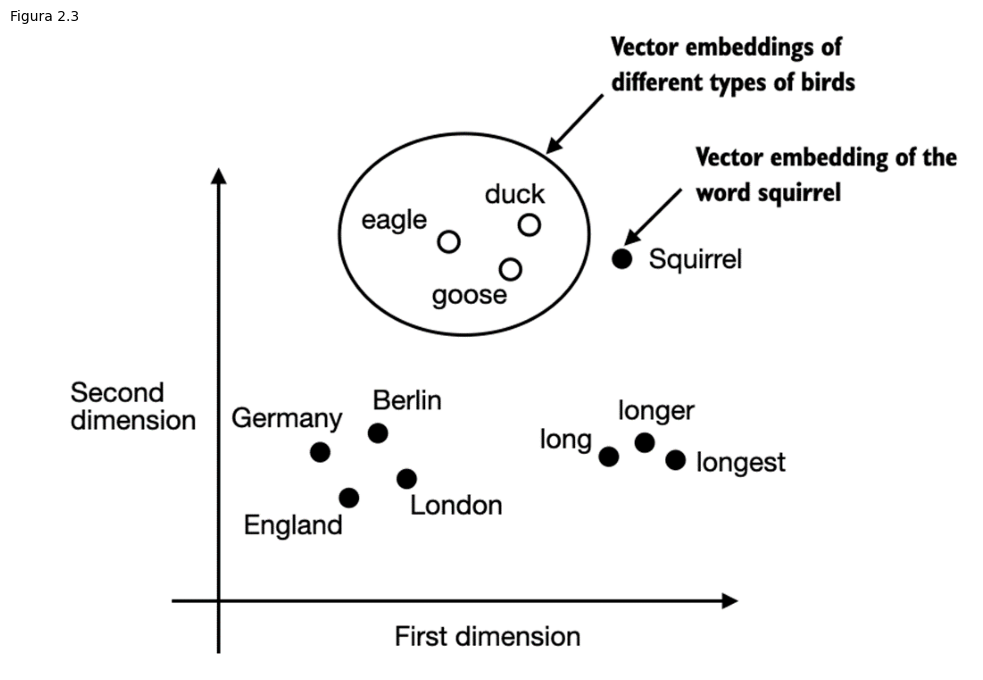


Se as representações de palavras forem bidimensionais, podemos plotá-las em um
gráfico de dispersão bidimensional para fins de visualização, como mostrado aqui.
Ao utilizar técnicas de incorporação de palavras, como o Word2Vec, palavras
correspondentes a conceitos semelhantes frequentemente aparecem próximas umas
das outras no espaço de representações. Por exemplo, diferentes tipos de pássaros
aparecem mais próximos uns dos outros no espaço de embedding em comparação
com países e cidades.


In [ ]:
# Visualização:
visualization('fig2_3.png', fig='Figura 2.3', text= '''
Se as representações de palavras forem \033[1mbidimensionais\033[0m, podemos plotá-las em um
\033[1mgráfico de dispersão bidimensional\033[0m para fins de visualização, como mostrado aqui.
Ao utilizar técnicas de incorporação de palavras, como o \033[1mWord2Vec\033[0m, palavras
correspondentes a conceitos semelhantes frequentemente aparecem próximas umas
das outras no espaço de representações. Por exemplo, diferentes tipos de pássaros
aparecem mais próximos uns dos outros no espaço de embedding em comparação
com países e cidades.''')

    As representações de palavras podem ter dimensões variáveis, de uma a
    milhares. Como mostrado na Figura 2.3, podemos escolher incorporações
    de palavras bidimensionais para fins de visualização. Uma dimensionalidade
    mais alta pode capturar relacionamentos mais sutis, mas ao custo da
    eficiência computacional.

    Embora possamos usar modelos pré-treinados, como o Word2Vec, para gerar
    incorporações para modelos de aprendizado de máquina, LLMs comumente
    produzem suas próprias incorporações que fazem parte da camada de entrada
    e são atualizadas durante o treinamento. A vantagem de otimizar as
    incorporações como parte do treinamento do LLM, em vez de usar o Word2Vec,
    é que as incorporações são otimizadas para a tarefa específica e os dados
    em questão. Implementaremos tais camadas de incorporação mais adiante neste
    capítulo. Além disso, LLMs também podem criar incorporações de saída
    contextualizadas, como discutimos no capítulo 3.

    As próximas seções deste capítulo guiarão pelos passos necessários para
    preparar as incorporações usadas por um LLM, que incluem dividir o texto
    em palavras, converter palavras em tokens e transformar tokens em vetores
    de incorporação.

# 2.2 Trabalhando com texto:

    Esta seção aborda como dividir o texto de entrada em tokens individuais,
    um passo de pré-processamento necessário para criar incorporações para
    um LLM. Esses tokens podem ser palavras individuais ou caracteres
    especiais, incluindo caracteres de pontuação.

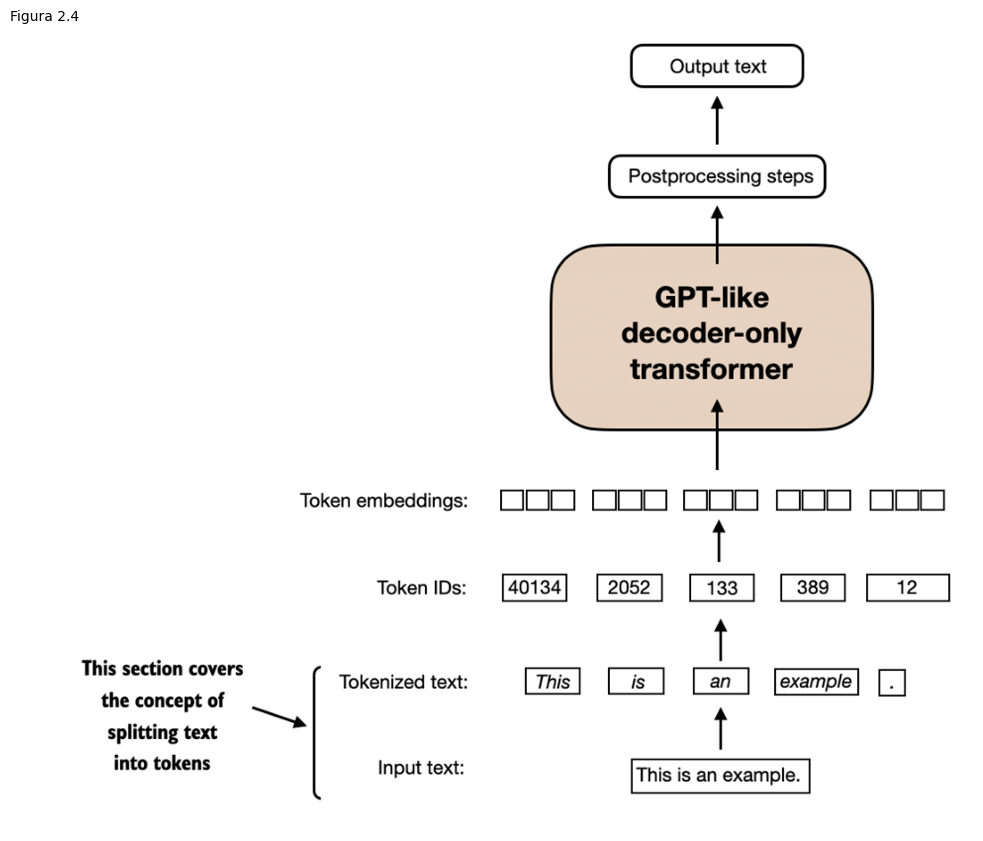


Uma visualização dos passos de processamento de texto abordados nesta seção no
contexto de um LLM. Aqui, dividimos um texto de entrada em tokens individuais,
que podem ser palavras ou caracteres especiais, como caracteres de pontuação.
Nas próximas seções, converteremos o texto em IDs de tokens e criaremos
incorporações de tokens.


In [ ]:
# Visualização:
visualization('fig2_4.png', fig='Figura 2.4', text='''
Uma visualização dos passos de processamento de texto abordados nesta seção no
contexto de um LLM. Aqui, dividimos um texto de entrada em tokens individuais,
que podem ser palavras ou caracteres especiais, como caracteres de pontuação.
Nas próximas seções, converteremos o texto em IDs de tokens e criaremos
incorporações de tokens.''')

## 2.2.1 Dados para treino:

    O livro utiliza um texto para o treinamento do modelo. Existem algumas
    formas de se aquisitar esse texto. Uma delas é simplesmente baixar para
    a sua máquina manualmente pelo github que o livro indica.

    Aqui, eu vou utilizar um método de scraping para baixar esse texto e
    utiliza-lo no treinamento do meu modelo.

In [ ]:
# Baixando imagem:
!curl -o fig2_4.png https://drek4537l1klr.cloudfront.net/raschka/v-5/Figures/02__image007.png

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  124k  100  124k    0     0   323k      0 --:--:-- --:--:-- --:--:--  323k


**Aquisitando o texto**

    O livro utiliza um texto base para realizar a explicação. Para evitar a
    necessidade de ir ter que baixar o texto a mão, aqui vamos baixar o texto
    pro scraping para facilitar o trabalho do leito.

In [ ]:
# bibliotecas para scraping:
import requests
import bs4
from bs4 import BeautifulSoup as bf

# Verões:
print('requests:', requests.__version__)
print('bs4:', bs4.__version__)

requests: 2.31.0
bs4: 4.12.3


In [ ]:
# Preparando Parser:
resposta = requests.get('https://en.wikisource.org/wiki/The_Verdict')
parser = resposta.text; parser

'<!DOCTYPE html>\n<html class="client-nojs" lang="en" dir="ltr">\n<head>\n<meta charset="UTF-8">\n<title>The Verdict - Wikisource, the free online library</title>\n<script>document.documentElement.className="client-js";RLCONF={"wgBreakFrames":false,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"348bf079-14dd-499c-9f69-93919fb53633","wgCanonicalNamespace":"","wgCanonicalSpecialPageName":false,"wgNamespaceNumber":0,"wgPageName":"The_Verdict","wgTitle":"The Verdict","wgCurRevisionId":10795836,"wgRevisionId":10795836,"wgArticleId":80998,"wgIsArticle":true,"wgIsRedirect":false,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Headers applying DefaultSort key","1908 works","Spoken works","PD-US"],"wgPageViewLanguage":"en","wgPageContentLanguage":"en","wgPageContentModel":"wikit

In [ ]:
# Endireitando a sopa de tretinhas:
beaut_parser = bf(parser, 'html.parser')

# Encontrando e concatenando texto:
raw_text = "\n".join([p.get_text() for p in beaut_parser.find_all('p')])

# Texto:
print(raw_text)

I HAD always thought Jack Gisburn rather a cheap genius--though a
good fellow enough--so it was no great surprise to me to hear that,
in the height of his glory, he had dropped his painting, married a
rich widow, and established himself in a villa on the Riviera.
(Though I rather thought it would have been Rome or Florence.)

"The height of his glory"--that was what the women called it. I can
hear Mrs. Gideon Thwing--his last Chicago sitter--deploring his
unaccountable abdication. "Of course it's going to send the value of
my picture 'way up; but I don't think of that, Mr. Rickham--the loss
to Arrt is all I think of." The word, on Mrs. Thwing's lips,
multiplied its _rs_ as though they were reflected in an endless
vista of mirrors. And it was not only the Mrs. Thwings who mourned.
Had not the exquisite Hermia Croft, at the last Grafton Gallery
show, stopped me before Gisburn's "Moon-dancers" to say, with tears
in her eyes: "We shall not look upon its like again"?

Well!--even through th

In [ ]:
# Contagem de Caracteres:
print(f"Numero total de caracteres: \033[1m{len(raw_text)}\033[0m")

Numero total de caracteres: 20784


    O escritor lê um arquivo txt, porém como eu fiz o processo de scraping,
    não vejo a necessidade de criar um arquivo txt, para depois le-lo como
    o livro segue. Como o scraping já está feito, então basta apenas seguir
    daqui.

**edit**

    Só depois de já ter feito o scraping, que eu fui ver o escritor avisa
    que o arquivo utilizado no livro já está em seu Github.

## Exemplo de tratamento de string:

    A quantidade de caracteres do texto bruto é muito grande então,
    antes de executarmos o tratamamento do texto bruto, vamos usar uma
    frase mais curta para elaborar o raciocínio que queremos executar.

**Divisão dos Caracteres:**

    O livro utiliza o método de "expressões regulares" para realizar a divisão
    inicial do vetor de sequências através do método "split". (Todavia, o método
    "split" é um método padrão do python, não precisaria de se importar uma
    biblioteca para isso).

**Expressões Regulares**

    As expressões regulares, também conhecidas como regex, são sequências
    de caracteres que definem um padrão de busca em texto. Elas são uma
    ferramenta poderosa e flexível para realizar operações de busca,
    correspondência e manipulação de strings com base em padrões específicos.

In [ ]:
# Bibliotecas de expressões regulares:
import re
re.__version__

'2.2.1'

In [ ]:
# Teste utilizando regex:
text_test = "Hello, world. This, is a test."
result = re.split(r'(\s)', text_test)
print(result) # Se fato o resultado é diferente deu só usar split

['Hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']



    Note que o esquema simples de tokenização acima funciona principalmente
    para separar o texto de exemplo em palavras individuais, no entanto,
    algumas palavras ainda estão conectadas a caracteres de pontuação que
    queremos ter como entradas separadas na lista.

In [ ]:
# Tratanmento de pontuação:
text_treatement = re.split(r'([,.]|\s)',text_test);print(text_treatement)

['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']


In [ ]:
# Gerando vetor final:
result = [item.strip() for item in text_treatement if item.strip()] #strip para tirar os espaços
print(result)

['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']


**Note que:**

    1. Ele faz questão que os caracteres de sinail façam parte no nosso
    vetor final. Isso pode explicar porque a utilização do regex nesse
    ponto, porque se fosse para fazer um vetor com as letras, isso poderia
    ser feito em apenas uma linha como podemos ver abaixo.

In [ ]:
# Vetor de palavras:
text_test.replace(',','').replace('.','').split()

['Hello', 'world', 'This', 'is', 'a', 'test']

    2. O método strip serve para recuperar um trecho específico
    da string, como no exemplo abaixo:

In [ ]:
txt1 = "     banana     "
txt2 = ",,,,,rrttgg.....banana....rrr"
x = txt1.strip()
y = txt2.strip(",.grt")
print(f'1:{x}, 2:{y}')

1:banana, 2:banana


    No exemplo em questão ele não é muito útil, tendo em vista que a string
    do jeito que o tratamento foi feito, a string já está "bem ajustada" nos
    caracteres que queremos. Ou seja, o primeiro elemento do vetor result já
    vai ser 'Hello' com ou sem strip, dito isso, talvez seja útil mais para
    frente durante a leitura.

**Remover ou não os espaços em branco**

    Ao desenvolver um tokenizador simples, se devemos codificar os espaços
    em branco como caracteres separados ou apenas removê-los depende de nossa
    aplicação e seus requisitos. Remover os espaços em branco reduz os
    requisitos de memória e computação. No entanto, manter os espaços em
    branco pode ser útil se treinarmos modelos que são sensíveis à estrutura
    exata do texto (por exemplo, código Python, que é sensível à indentação
    e espaçamento). Aqui, removemos os espaços em branco para simplicidade e
    concisão das saídas tokenizadas. Mais tarde, faremos a transição para um
    esquema de tokenização que inclui espaços em branco.

In [ ]:
# Baixando imagem:
!curl -o fig2_5.png https://drek4537l1klr.cloudfront.net/raschka/v-5/Figures/02__image009.png

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 17039  100 17039    0     0  40994      0 --:--:-- --:--:-- --:--:-- 40959


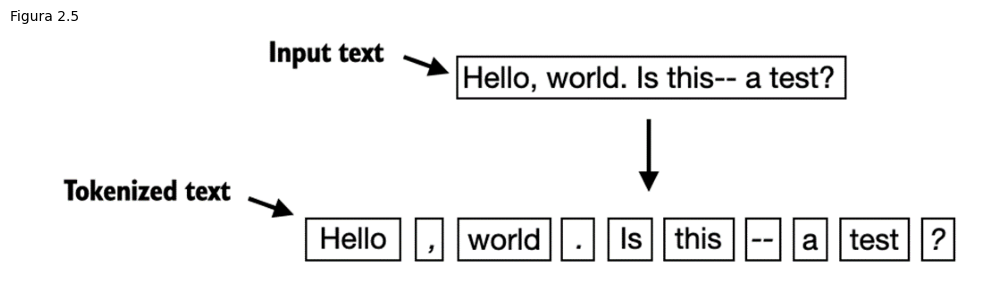


O esquema de tokenização que implementamos até agora divide o texto em palavras
individuais e caracteres de pontuação. No exemplo específico mostrado nesta figura,
o texto de amostra é dividido em 10 tokens individuais.


In [ ]:
# Visualização:
visualization('fig2_5.png', fig='Figura 2.5', text=f'''
O esquema de tokenização que implementamos até agora divide o texto em palavras
individuais e caracteres de pontuação. No exemplo específico mostrado nesta figura,
o texto de amostra é dividido em \033[1m10\033[0m tokens individuais.''')